In [15]:
import torch
import torchvision
import torchvision.transforms as T
import random
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
from cs231n.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD
from PIL import Image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [22]:
def preprocess(img, size=224):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(), std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        T.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

def blur_image(x, sigma=1):
    x_np = x.cpu().clone().numpy()
    x_np = gaussian_filter1d(x_np, sigma, axis=2)
    x_np = gaussian_filter1d(x_np, sigma, axis=3)
    x.copy_(torch.Tensor(x_np).type_as(x))
    return x

In [23]:
model = torchvision.models.squeezenet1_1(pretrained=True)

for param in model.parameters():
    param.requries_grad = False

/home/lzhang/anaconda3/envs/cs231n/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/home/lzhang/anaconda3/envs/cs231n/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


In [24]:
from cs231n.data_utils import load_imagenet_val

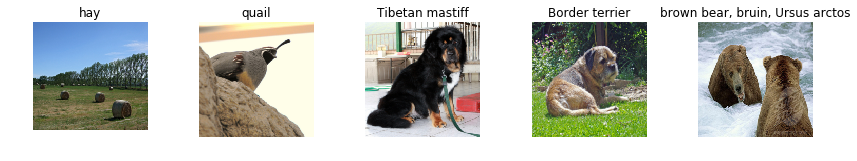

In [25]:
X, y, class_names = load_imagenet_val(num=5)

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

### Saliency Maps

In [52]:
def compute_saliency_maps(X, y, model):
    model.eval()
    X.requires_grad_()
    saliency = None
    
    scores = model(X)
    correct_score = torch.gather(scores, dim=1, index=y.view(-1, 1)).squeeze()
    loss = torch.sum(correct_score)
    loss.backward()
    saliency, _ = torch.max(X.grad.data.abs(), dim=1)
    return saliency

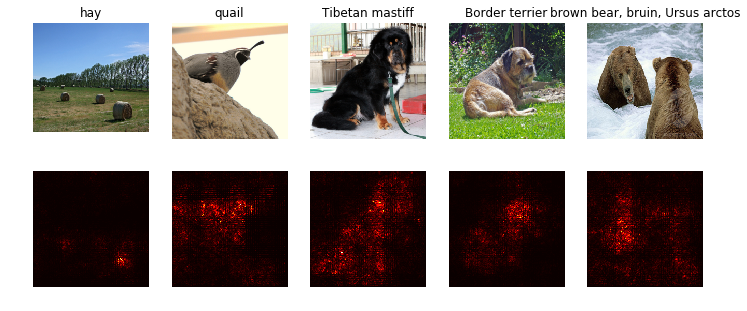

In [54]:
def show_saliency_maps(X, y):
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = torch.LongTensor(y)
    
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)
    saliency = saliency.numpy()
    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()

show_saliency_maps(X, y)

### Fooling Images

In [77]:
def make_fooling_image(X, target_y, model):
    X_fooling = X.clone()
    X_fooling = X_fooling.requires_grad_()
    
    learning_rate = 1
    
    for i in range(100):
        score = model(X_fooling)
        pred = score.max(dim=1)[1][0]
        if pred == target_y:
            break
        score[0, target_y].backward()
        dx = X_fooling.grad.data
        X_fooling.data += learning_rate * dx / dx.norm()
        X_fooling.grad.zero_()
    
    return X_fooling

In [78]:
idx = 0
target_y = 6

X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
X_fooling = make_fooling_image(X_tensor, target_y, model)

scores = model(X_fooling)
assert target_y == scores.data.max(1)[1][0].item(), 'Not fooled!'

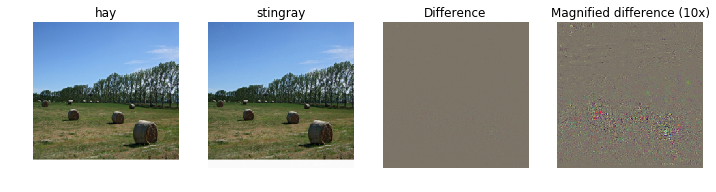

In [79]:
X_fooling_np = deprocess(X_fooling.clone())
X_fooling_np = np.asarray(X_fooling_np).astype(np.uint8)

plt.subplot(1, 4, 1)
plt.imshow(X[idx])
plt.title(class_names[y[idx]])
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(X_fooling_np)
plt.title(class_names[target_y])
plt.axis('off')

plt.subplot(1, 4, 3)
X_pre = preprocess(Image.fromarray(X[idx]))
diff = np.asarray(deprocess(X_fooling - X_pre, should_rescale=False))
plt.imshow(diff)
plt.title('Difference')
plt.axis('off')

plt.subplot(1, 4, 4)
diff = np.asarray(deprocess(10 * (X_fooling - X_pre), should_rescale=False))
plt.imshow(diff)
plt.title('Magnified difference (10x)')
plt.axis('off')

plt.gcf().set_size_inches(12, 5)
plt.show()

### Class Visualization

In [81]:
def jitter(X, ox, oy):
    if ox != 0:
        left = X[:, :, :, :-ox]
        right = X[:, :, :, -ox:]
        X = torch.cat([right, left], dim=3)
    if oy != 0:
        top = X[:, :, :-oy]
        bottom = X[:, :, -oy:]
        X = torch.cat([bottom, top], dim=2)
    return X

In [90]:
def create_class_visualization(target_y, model, dtype, **kwargs):
    model.type(dtype)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)

    img = torch.randn(1, 3, 224, 224).mul_(1.0).type(dtype).requires_grad_()
    
    for t in range(num_iterations):
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img.data.copy_(jitter(img.data, ox, oy))
        
        score = model(img)
        loss = score[0, target_y] - l2_reg * torch.sum(img.data * img.data)
        loss.backward()
        dx = img.grad.data
        img.data += learning_rate * dx / dx.norm()
        img.grad.data.zero_()
        
        img.data.copy_(jitter(img.data, -ox, -oy))
    
        for c in range(3):
            lo = float(-SQUEEZENET_MEAN[c] / SQUEEZENET_STD[c])
            hi = float((1.0 - SQUEEZENET_MEAN[c]) / SQUEEZENET_STD[c])
            img.data[:, c].clamp_(min=lo, max=hi)

        if t % blur_every == 0:
            blur_image(img.data, sigma=0.5)

        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            plt.imshow(deprocess(img.data.clone().cpu()))
            class_name = class_names[target_y]
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()

    return deprocess(img.data.cpu())

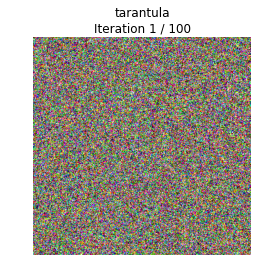

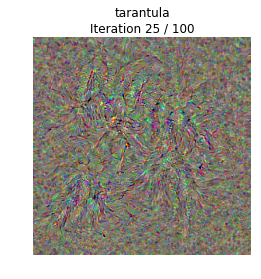

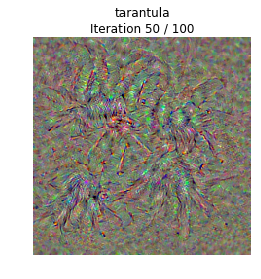

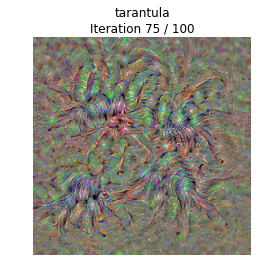

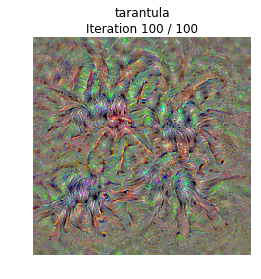

In [91]:
dtype = torch.FloatTensor
model.type(dtype)
target_y = 76
out = create_class_visualization(target_y, model, dtype)

mobile home, manufactured home


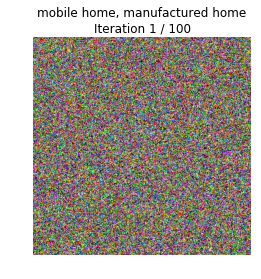

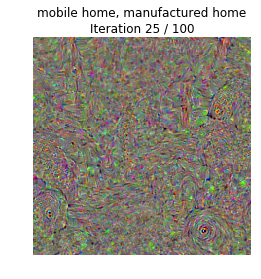

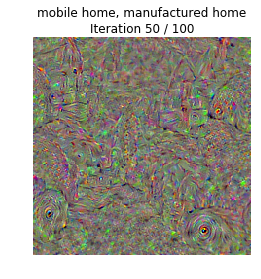

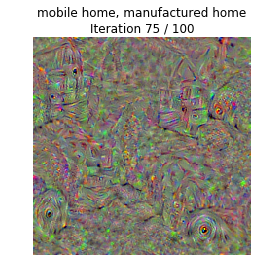

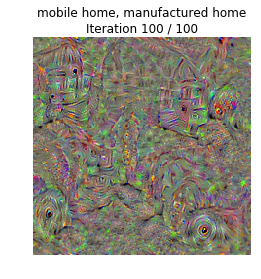

In [92]:
target_y = np.random.randint(1000)
print(class_names[target_y])
X = create_class_visualization(target_y, model, dtype)